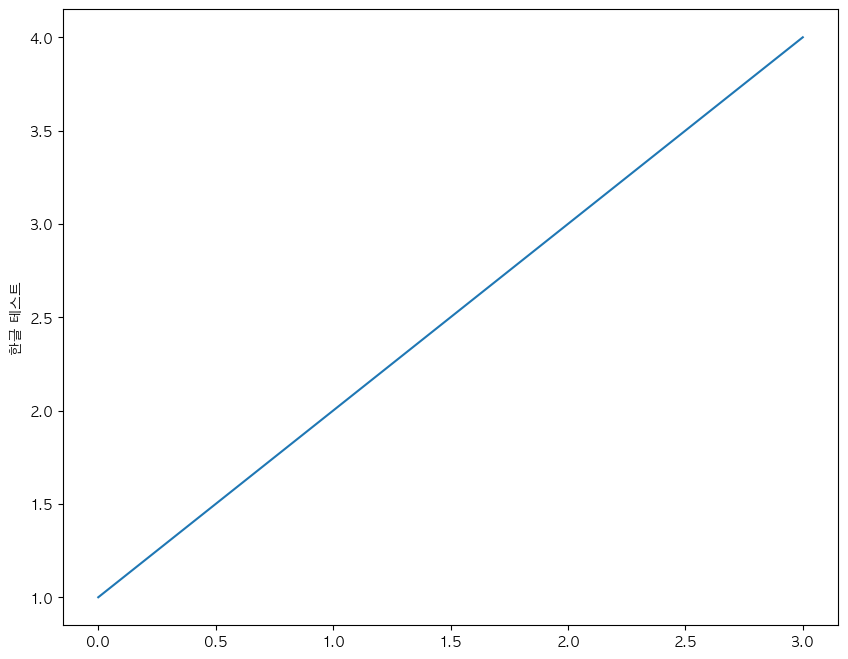

In [2]:
## import library
import trino
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


plt.rcParams['figure.figsize'] = [10, 8]

conn = trino.dbapi.connect(
    host='kakaoent-presto-adhoc.kakaoent.io',
    port=8443,
    user='samuel-ch',
    catalog='hadoop_kent',
    schema='default',                          # 사용할 Database 지정
    http_scheme='https',
    auth=trino.auth.BasicAuthentication("samuel-ch", "melon!Q2w3e"),  # 카카오 LDAP이 아닌 하둡 LDAP 입력
    http_headers={
        'X-Presto-User': 'samuel-ch',
        'X-Presto-Time-Zone': 'Asia/Seoul'
    },
)
cur = conn.cursor()

# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '11px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', '#6d6d6d'),
  ('background-color', '#f7f7f9')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '11px')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
  ]

cm = sns.light_palette("green", as_cmap=True)

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# AppleGothic 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

# 테스트 플롯
plt.plot([1, 2, 3, 4])
plt.ylabel('한글 테스트')
plt.show()

In [3]:
# 주간일평균 자발적/비자발적 해지율 집계
out_prod_ratio_query = '''
select split(f3.yw_nm,'~')[1] as yw_strt_date
     , f3.yw_nm
     , f3.yw_nm2
     , promo_grp_nm
     , sum(normal_out_prod_cnt) as normal_out_prod_cnt
     , avg(normal_out_prod_ratio) as avg_normal_out_prod_ratio
     , sum(fail_out_prod_cnt) as fail_out_prod_cnt
     , avg(fail_out_prod_ratio) as avg_fail_out_prod_ratio
from(
select dt
     , if(t4.promo_grp_cd = 65,'tms프로모션','기타프로모션') as promo_grp_nm
     , count(distinct buy_no) as prod_cnt
     , count(DISTINCT IF(T1.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),T1.BUY_NO)) AS normal_out_prod_cnt
     , count(DISTINCT IF(T1.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,T1.BUY_NO)) AS trgt_prod_cnt
     , CAST(count(DISTINCT IF(T1.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201),T1.BUY_NO)) AS DOUBLE)/CAST(count(DISTINCT IF(T1.PROD_STAT_CD IN (3100, 3401, 3701, 4000, 3200, 3201,3300, 3301, 3903, 3902, 3900) OR at_pay_trgt_yn = 1,T1.BUY_NO)) AS DOUBLE)*100 AS normal_out_prod_ratio
     , count(DISTINCT IF(t1.at_pay_trgt_yn = 1 and T1.AT_PAY_SUCC_YN = 0, T1.BUY_NO)) as fail_out_prod_cnt
     , CAST(count(DISTINCT IF(t1.at_pay_trgt_yn = 1 and T1.AT_PAY_SUCC_YN = 0, T1.BUY_NO)) AS DOUBLE)/CAST(count(DISTINCT IF(T1.at_pay_trgt_yn = 1,T1.BUY_NO)) AS DOUBLE)*100 AS fail_out_prod_ratio
from hadoop_kent.melon_ma_stat_production.f_prod_user_fxmt_dt t1
left join hadoop_kent.melon_ma_stat_production.d_prod t2 on t1.prod_id = t2.prod_id
left join hadoop_kent.melon_ma_stat_production.d_promo t3 on t1.promo_id = t3.promo_id
left join hadoop_kent.melon_ma_stat_production.d_promo_grp t4 on t3.promo_grp_cd = t4.promo_grp_cd
where log_date between '20240101' and '20250330'
and t2.PROD_ATTR_CD NOT IN (10040, 10050) /*종량제외*/
and t2.PROD_SELL_PRT_CD = 60000 /*B2C*/
and t2.PROD_PRT_CD = 20000 /*클럽상품*/
and t1.PF_YN = 1
and (t1.at_pay_trgt_yn = 1 or 
     t1.prod_stat_cd in (3100, 3401, 3701, 3200, 3201, 3400, 3402, 3300, 3301, 3903, 3900, 3902, 3500, 3700)
     )
group by 1,2
) f1
left join hadoop_kent.melon_ma_stat_production.d_base_dt f2 on f1.dt = f2.dt
left join hadoop_kent.melon_ma_stat_production.d_base_yw f3 on f2.yw = f3.yw
group by 1,2,3,4
order by 4,1



'''

cur.execute(out_prod_ratio_query)

results = cur.fetchall()
colnames = [part[0] for part in cur.description]

out_prod_ratio = pd.DataFrame(results, columns=colnames)

cur.cancel()
conn.close()
out_prod_ratio.head()

,yw_strt_date,yw_nm,yw_nm2,promo_grp_nm,normal_out_prod_cnt,avg_normal_out_prod_ratio,fail_out_prod_cnt,avg_fail_out_prod_ratio
0,2024-01-01,2024-01-01~2024-01-07,1월1주,tms프로모션,1038,10.022278,1260,13.585261
1,2024-01-08,2024-01-08~2024-01-14,1월2주,tms프로모션,748,7.763771,1193,13.856169
2,2024-01-15,2024-01-15~2024-01-21,1월3주,tms프로모션,693,7.209487,1116,12.691872
3,2024-01-22,2024-01-22~2024-01-28,1월4주,tms프로모션,1392,13.865208,1185,14.119816
4,2024-01-29,2024-01-29~2024-02-04,2월1주,tms프로모션,1234,9.581652,1301,11.950531


/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_51791/1740686933.py:11: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


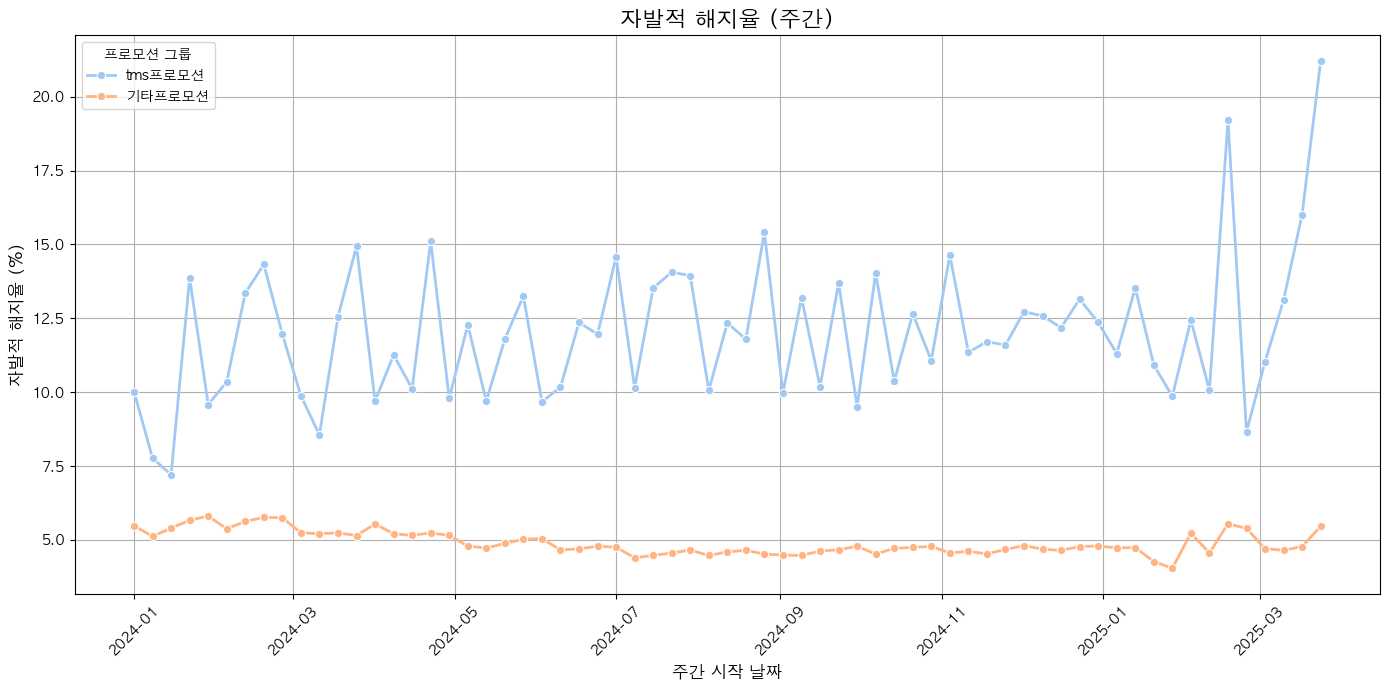

/var/folders/qw/6lks7c5d14scf7qtctm8m6jh0000gn/T/ipykernel_51791/1740686933.py:31: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.lineplot(


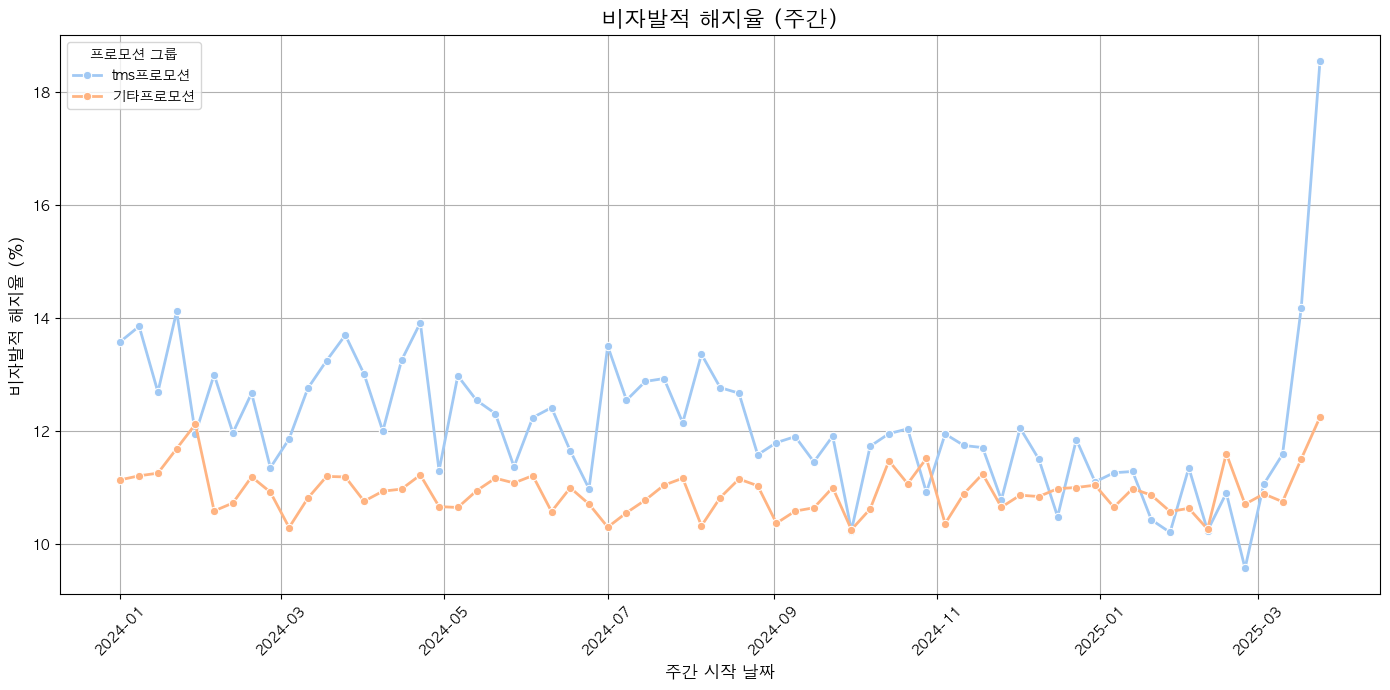

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 데이터 준비
# out_prod_ratio 데이터프레임이 이미 생성되었다고 가정
out_prod_ratio["yw_strt_date"] = pd.to_datetime(out_prod_ratio["yw_strt_date"])  # 날짜 형식 변환

# 2. 자발적 해지율 라인 플롯
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=out_prod_ratio, 
    x="yw_strt_date", 
    y="avg_normal_out_prod_ratio", 
    hue="promo_grp_nm", 
    marker="o", 
    palette=sns.color_palette("pastel"),  # 밝은 색상 팔레트
    linewidth=2  # 라인 굵기 설정
)
plt.title("자발적 해지율 (주간)", fontsize=16)
plt.xlabel("주간 시작 날짜", fontsize=12)
plt.ylabel("자발적 해지율 (%)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹", loc="upper left")  # 범례를 그래프 안쪽 상단 왼쪽으로 배치
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. 비자발적 해지율 라인 플롯
plt.figure(figsize=(14, 7))
sns.lineplot(
    data=out_prod_ratio, 
    x="yw_strt_date", 
    y="avg_fail_out_prod_ratio", 
    hue="promo_grp_nm", 
    marker="o", 
    palette=sns.color_palette("pastel"),  # 밝은 색상 팔레트
    linewidth=2  # 라인 굵기 설정
)
plt.title("비자발적 해지율 (주간)", fontsize=16)
plt.xlabel("주간 시작 날짜", fontsize=12)
plt.ylabel("비자발적 해지율 (%)", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title="프로모션 그룹", loc="upper left")  # 범례를 그래프 안쪽 상단 왼쪽으로 배치
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# 프로모션 그룹별 자발적/비자발적 해지율 평균 계산
pivot_table = out_prod_ratio.pivot_table(
    index="promo_grp_nm",  # 프로모션 그룹을 행으로 설정
    values=["avg_normal_out_prod_ratio", "avg_fail_out_prod_ratio"],  # 자발적/비자발적 해지율
    aggfunc="mean"  # 평균 계산
)

# 결과 출력
print("프로모션 그룹별 자발적/비자발적 해지율 평균:")
print(pivot_table)

프로모션 그룹별 자발적/비자발적 해지율 평균:
              avg_fail_out_prod_ratio  avg_normal_out_prod_ratio
promo_grp_nm                                                    
tms프로모션                     12.136716                  12.026214
기타프로모션                      10.929824                   4.904333


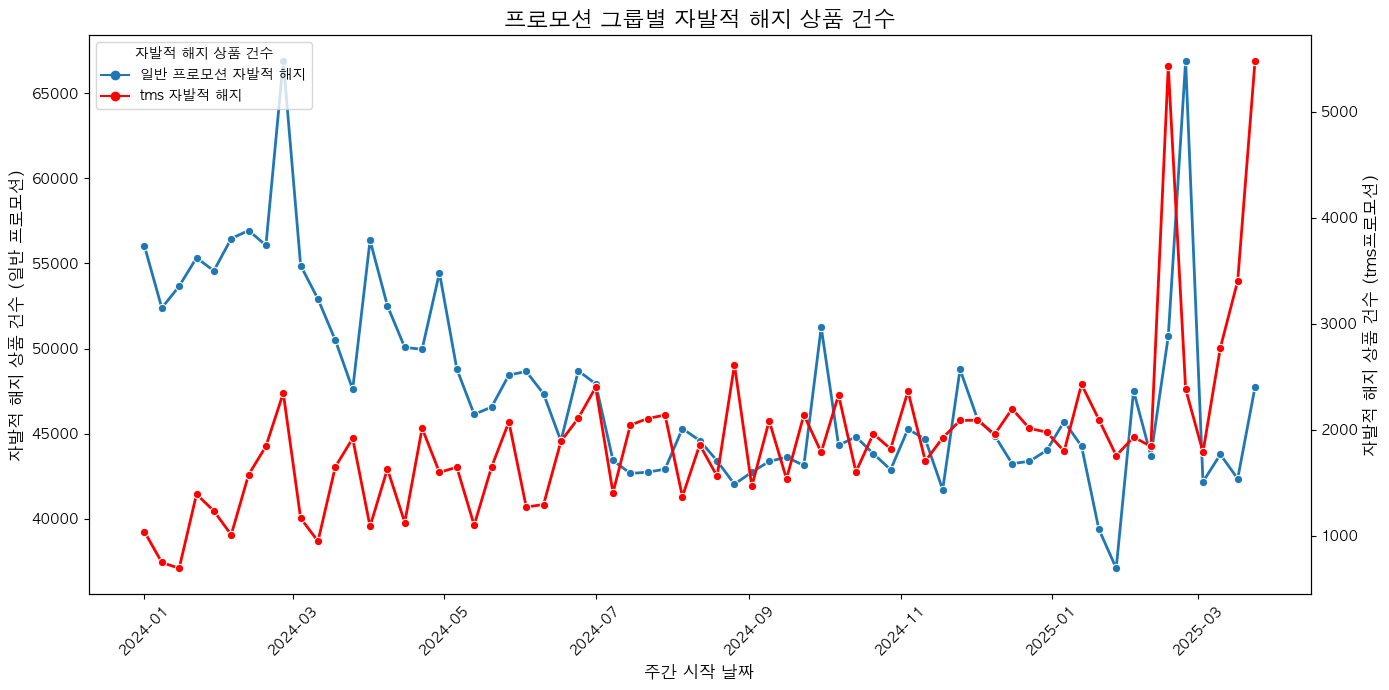

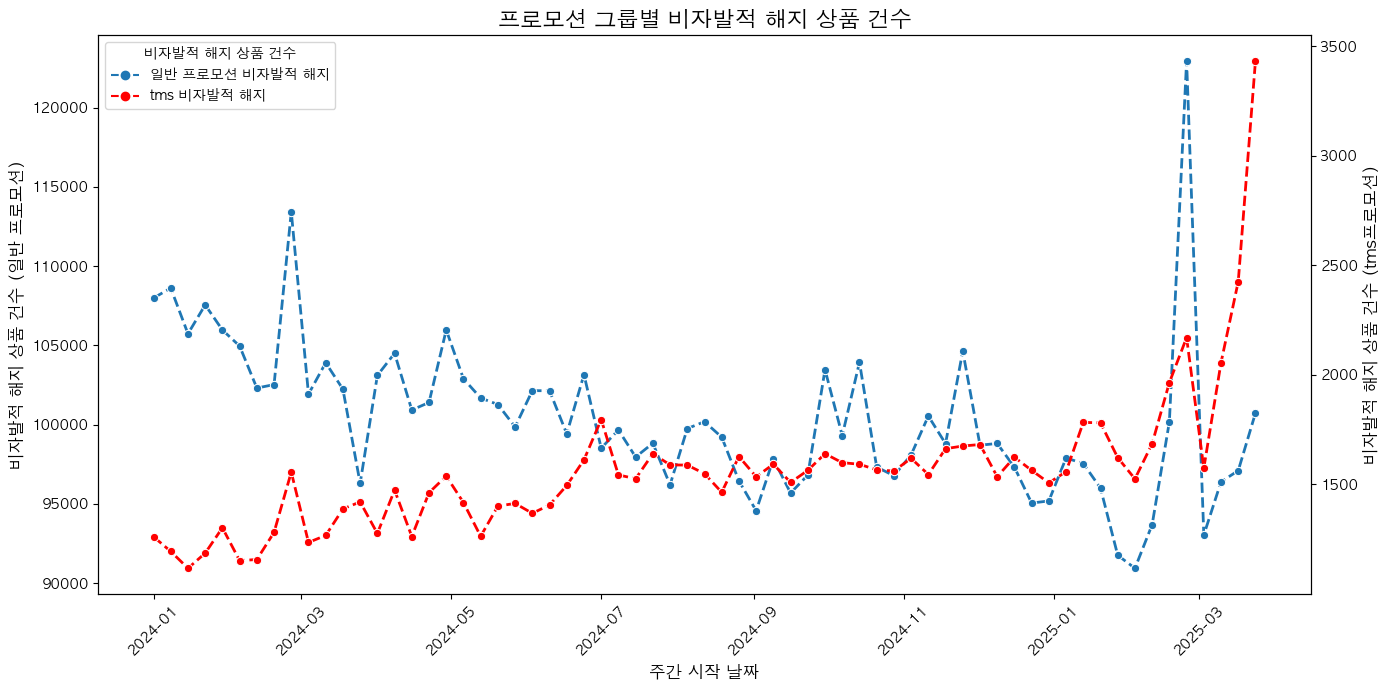

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1. 데이터 준비
# 날짜 형식 변환
out_prod_ratio["yw_strt_date"] = pd.to_datetime(out_prod_ratio["yw_strt_date"])

# 2. 자발적 해지 건수 플롯
plt.figure(figsize=(14, 7))

# 왼쪽 Y축: 자발적 해지 건수 (tms프로모션 제외)
non_tms_data = out_prod_ratio[out_prod_ratio["promo_grp_nm"] != "tms프로모션"]
sns.lineplot(
    data=non_tms_data,
    x="yw_strt_date",
    y="normal_out_prod_cnt",
    hue="promo_grp_nm",
    marker="o",
    palette="tab10",
    linewidth=2,
    legend=False  # 자동 범례 비활성화
)

# 오른쪽 Y축: tms프로모션
tms_data = out_prod_ratio[out_prod_ratio["promo_grp_nm"] == "tms프로모션"]
ax = plt.gca()  # 현재 축 가져오기
ax2 = ax.twinx()  # 오른쪽 Y축 생성

sns.lineplot(
    data=tms_data,
    x="yw_strt_date",
    y="normal_out_prod_cnt",
    color="red",
    marker="o",
    linewidth=2,
    ax=ax2,
    legend=False  # 자동 범례 비활성화
)

# 그래프 설정
ax.set_title("프로모션 그룹별 자발적 해지 상품 건수", fontsize=16)
ax.set_xlabel("주간 시작 날짜", fontsize=12)
ax.set_ylabel("자발적 해지 상품 건수 (일반 프로모션)", fontsize=12)
ax2.set_ylabel("자발적 해지 상품 건수 (tms프로모션)", fontsize=12)
ax.tick_params(axis="x", rotation=45)

# 범례 설정: 한 박스로 합치기
custom_legend = [
    Line2D([0], [0], color="tab:blue", marker="o", label="일반 프로모션 자발적 해지"),
    Line2D([0], [0], color="red", marker="o", label="tms 자발적 해지")
]
plt.legend(handles=custom_legend, loc="upper left", title="자발적 해지 상품 건수")

plt.tight_layout()
plt.show()

# 3. 비자발적 해지 건수 플롯
plt.figure(figsize=(14, 7))

# 왼쪽 Y축: 비자발적 해지 건수 (tms프로모션 제외)
sns.lineplot(
    data=non_tms_data,
    x="yw_strt_date",
    y="fail_out_prod_cnt",
    hue="promo_grp_nm",
    marker="o",
    palette="tab10",
    linewidth=2,
    linestyle="--",
    legend=False  # 자동 범례 비활성화
)

# 오른쪽 Y축: tms프로모션
ax = plt.gca()  # 현재 축 가져오기
ax2 = ax.twinx()  # 새로운 오른쪽 Y축 생성

sns.lineplot(
    data=tms_data,
    x="yw_strt_date",
    y="fail_out_prod_cnt",
    color="red",
    marker="o",
    linewidth=2,
    linestyle="--",
    ax=ax2,
    legend=False  # 자동 범례 비활성화
)

# 그래프 설정
ax.set_title("프로모션 그룹별 비자발적 해지 상품 건수", fontsize=16)
ax.set_xlabel("주간 시작 날짜", fontsize=12)
ax.set_ylabel("비자발적 해지 상품 건수 (일반 프로모션)", fontsize=12)
ax2.set_ylabel("비자발적 해지 상품 건수 (tms프로모션)", fontsize=12)
ax.tick_params(axis="x", rotation=45)

# 범례 설정: 한 박스로 합치기
custom_legend = [
    Line2D([0], [0], color="tab:blue", marker="o", linestyle="--", label="일반 프로모션 비자발적 해지"),
    Line2D([0], [0], color="red", marker="o", linestyle="--", label="tms 비자발적 해지")
]
plt.legend(handles=custom_legend, loc="upper left", title="비자발적 해지 상품 건수")

plt.tight_layout()
plt.show()